# Jane Street - EDA XGB

In [1]:
# use the older xgboost
!pip uninstall xgboost -y
!pip install xgboost==1.2.1

import joblib
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.feature_selection import ColumnSelector

from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier

In [2]:
# read data as 32 bit floats
file = os.path.join(os.pardir, "input", "jane-street-market-prediction", "train.csv")
dtype = {c: np.float32 for c in pd.read_csv(file, nrows=1).columns}
full_df = pd.read_csv(file, engine="c", dtype=dtype)

# split into training and validation
train_df = full_df[full_df["date"].between(0, 400)]
valid_df = full_df[full_df["date"].between(425, 500)]

# build features and labels
#features = ["feature_0", "feature_1", "feature_3", "feature_5", "feature_8", "feature_11",
#            "feature_17", "feature_19", "feature_20", "feature_21", "feature_23", "feature_27",
#            "feature_29", "feature_30", "feature_31", "feature_33", "feature_34", "feature_37",
#            "feature_39", "feature_41", "feature_42", "feature_43", "feature_44", "feature_45",
#            "feature_47", "feature_53", "feature_60", "feature_62", "feature_64", "feature_79",
#            "feature_83", "feature_85", "feature_87", "feature_88", "feature_90", "feature_91",
#            "feature_94", "feature_95", "feature_97", "feature_100", "feature_103", "feature_106"]
features = [f"feature_{x}" for x in range(130)]
train_X = train_df[features].to_numpy()
valid_X = valid_df[features].to_numpy()
train_y = train_df["resp"].gt(0.0).astype(np.uint8).to_numpy()
valid_y = valid_df["resp"].gt(0.0).astype(np.uint8).to_numpy()

In [3]:
# impute and normalize data
cs = ColumnSelector(cols=(0,  1,  3,  5,  8,  11, 17, 19, 20, 21, 23,
                          27, 29, 30, 31, 33, 34, 37, 39, 41, 42, 43,
                          44, 45, 47, 53, 60, 62, 64, 79, 83, 85, 87,
                          88, 90, 91, 94, 95, 97, 100, 103, 106))
si = SimpleImputer(strategy="constant", fill_value=-200)
pp = make_pipeline(cs, si)

train_X = pp.fit_transform(train_X)
valid_X = pp.transform(valid_X)

In [4]:
# model parameters
params = {"max_depth": list(range(3, 10)),
          "min_child_weight": list(range(1, 6))
         }

params = {"max_depth": [6],
          "min_child_weight": [1],
          "gamma": [x * 1e-5 for x in range(10)]
         }

params = {"max_depth": [6],
          "min_child_weight": [1],
          "gamma": [0],
          "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
         }

params = {"max_depth": [6],
          "min_child_weight": [1],
          "gamma": [0],
          "subsample": [1.0],
          "colsample_bytree": [1.0],
          "reg_alpha": [160, 180, 200, 220, 240],
          "reg_lambda": [0.5, 0.6, 0.7, 0.8]
         }

params = {"max_depth": [6],
          "min_child_weight": [1],
          "gamma": [0],
          "subsample": [1.0],
          "colsample_bytree": [1.0],
          "reg_alpha": [200],
          "reg_lambda": [0.7],
          "learning_rate": [x * 0.05 for x in range(1, 11)]
         }

params = {"max_depth": [5, 6, 7],
          "min_child_weight": [1],
          "gamma": [0],
          "subsample": [0.8, 0.9, 1.0],
          "colsample_bytree": [0.8, 0.9, 1.0],
          "reg_alpha": [175, 200, 225],
          "reg_lambda": [0.6, 0.7, 0.8],
          "learning_rate": [0.01, 0.05, 0.1]
         }

params = {"max_depth": [6],
          "min_child_weight": [1],
          "gamma": [0],
          "subsample": [0.95, 1.0],
          "colsample_bytree": [0.85, 0.9, 0.95],
          "reg_alpha": [200, 225, 250],
          "reg_lambda": [0.75, 0.8, 0.85, 0.9],
          "learning_rate": [0.1, 0.15, 0.2]
         }

params = {"max_depth": [6],
          "min_child_weight": [1, 2],
          "gamma": [0],
          "subsample": [1.0],
          "colsample_bytree": [0.9],
          "reg_alpha": [210, 217, 225, 233, 240],
          "reg_lambda": [0.6, 0.65, 0.7, 0.75],
          "learning_rate": [0.075, 0.1, 0.125]
         }

params = {"max_depth": [6],
          "min_child_weight": [1],
          "gamma": [0],
          "subsample": [1.0],
          "colsample_bytree": [0.9],
          "reg_alpha": [225],
          "reg_lambda": [0.75],
          "learning_rate": [0.1]
         }
    
# early stopping
fit_params = {"early_stopping_rounds": 50,
              "eval_metric": "auc",
              "eval_set": [(valid_X, valid_y)],
              "verbose": False}

# base model
clf = XGBClassifier(n_estimators=1000, tree_method="gpu_hist", random_state=13)

# setup the data for parameter search
full_X = np.vstack([train_X, valid_X])
full_y = np.append(train_y, valid_y)
test_fold = np.append(np.full(train_X.shape[0], -1, dtype=np.int), np.zeros(valid_X.shape[0], dtype=np.int))
ps = PredefinedSplit(test_fold)

# find the parameters with best AUC score
cv = GridSearchCV(clf, params, cv=ps, scoring="roc_auc", refit=False)
cv.fit(full_X, full_y, **fit_params)

# show the best parameters
print(f"Highest AUC = {round(cv.best_score_, 4)} with parameters:")
for k, v in cv.best_params_.items():
    print(f"  {k} = {v}")

# need to refit the best model manually since the built-in refitting will refit on full_X, full_y
# first recover the training history by refitting with early stopping
model = XGBClassifier(n_estimators=1000, tree_method="gpu_hist", random_state=13, **cv.best_params_)
fit_params["verbose"] = True
model.fit(train_X, train_y, **fit_params)

# finally refit the model with the best number of estimators
model.set_params(n_estimators=model.best_iteration)
model.fit(train_X, train_y)

Highest AUC = 0.5328 with parameters:
  colsample_bytree = 0.9
  gamma = 0
  learning_rate = 0.1
  max_depth = 6
  min_child_weight = 1
  reg_alpha = 225
  reg_lambda = 0.75
  subsample = 1.0
[0]	validation_0-auc:0.51576
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.51826
[2]	validation_0-auc:0.51782
[3]	validation_0-auc:0.51763
[4]	validation_0-auc:0.51770
[5]	validation_0-auc:0.51747
[6]	validation_0-auc:0.51803
[7]	validation_0-auc:0.51818
[8]	validation_0-auc:0.51845
[9]	validation_0-auc:0.51865
[10]	validation_0-auc:0.51883
[11]	validation_0-auc:0.51897
[12]	validation_0-auc:0.51981
[13]	validation_0-auc:0.52026
[14]	validation_0-auc:0.52053
[15]	validation_0-auc:0.52104
[16]	validation_0-auc:0.52114
[17]	validation_0-auc:0.52127
[18]	validation_0-auc:0.52155
[19]	validation_0-auc:0.52180
[20]	validation_0-auc:0.52209
[21]	validation_0-auc:0.52255
[22]	validation_0-auc:0.52265
[23]	validation_0-auc:0.52272
[24]	validation_0-auc:0.52301
[25]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=254, n_jobs=0, num_parallel_tree=1, random_state=13,
              reg_alpha=225, reg_lambda=0.75, scale_pos_weight=1, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

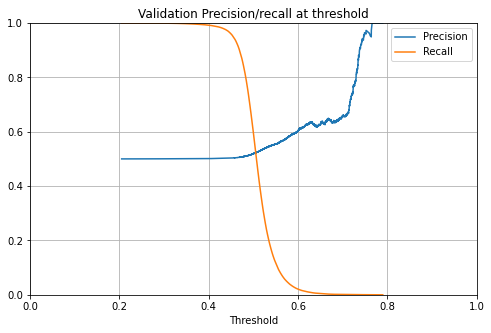

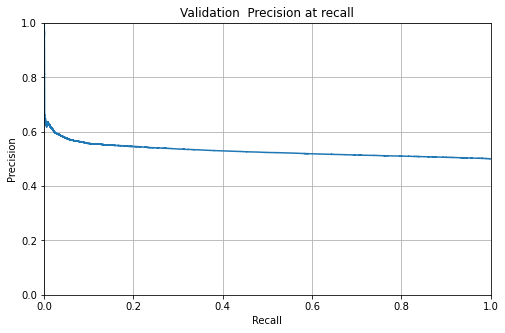

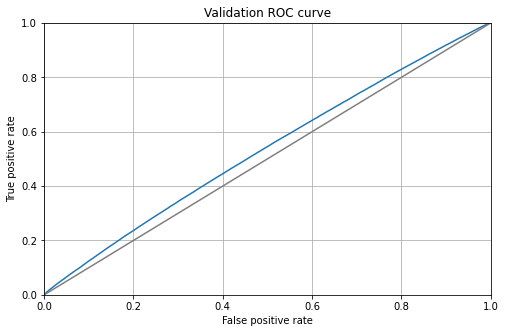

Validation AUC: 0.5327747466662789


In [5]:
probs = model.predict_proba(valid_X)
probs = probs[:, 1]

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(valid_y, probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Validation Precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Validation  Precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(valid_y, probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Validation ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# AUC
print(f"Validation AUC: {roc_auc_score(valid_y, probs)}")

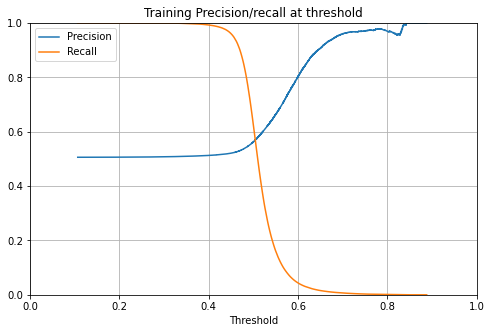

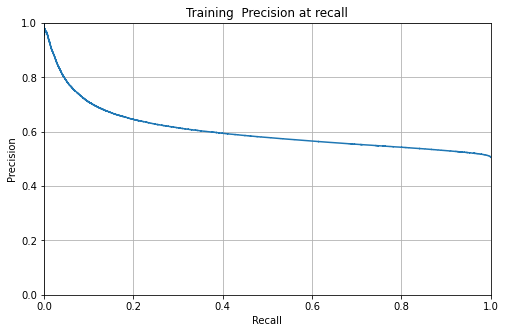

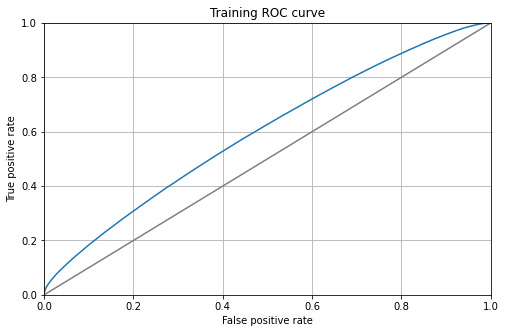

Training AUC: 0.5971912584024601


In [6]:
probs = model.predict_proba(train_X)
probs = probs[:, 1]

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(train_y, probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Training Precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Training  Precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(train_y, probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Training ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# AUC
print(f"Training AUC: {roc_auc_score(train_y, probs)}")

In [7]:
# save model and preprocessing parameters
#params = {"impute": -200, "features": features}
#with open("params.json", "w") as f:
#    json.dump(params, f)

joblib.dump(pp, "preprocessor.pkl")
model.save_model("model.xgb")